# Midterm Exam (part 2) - Computational Physics I

### Deadline: Tuesday 8 April 2024 (by 19h00)
### Name: Rolando Sánchez

## Part 2. (20 points) Two-Body Problem: Black Hole

This problem consists of developing your own standalone python module to simulate a two-body problem. The module accepts initial parameters from the user and delivers customised simulations of two-body systems where the interaction between them is of gravitational nature, accounting for relativistic effects.

We will assume that the most massive object of mass $M$ is a **black hole** and it is located at the origin of the Cartesian coordinate system $(x,y)$, while the other object is a **planet the size of Earth** with mass $m=m_{\rm earth}$ or smaller, orbiting around the black hole. In this coordinate system, the position of the planet is $\vec{r} = x\hat{x} + y\hat{y}$, which is the vector pointing from the black hole to the planet. 

To account for relativistic effects, we need to modify the Newtonian equations of motion. We will use the post-Newtonian approximation, which provides an adequate balance between accuracy and computational efficiency for orbits around the black hole. The **relativistic ODE system** describing the motion of the planet is:

$$\frac{d\vec{r}}{dt}=\vec{v}$$

$$m\frac{d\vec{v}}{dt} = -\frac{G\,m\,M}{r^3} \vec{r} \left( 1 + \frac{3\,L^2}{r^2\,c^2} \right)$$

where $L = |\vec{r} \times \vec{v}|$ is the specific angular momentum of the planet, and $c$ is the speed of light. The correction term, $\frac{3\,L^2}{r^2\,c^2}$, accounts for the relativistic precession of the orbit. Note that $m$ cancels out in the above equation.

In addition, **Kepler’s third law** for $M\gg m$ states that: $4\,\pi^2\,a^3\approx{G\,M}\,T^2$, where $a$ is the semi-major axis of the elliptical relative motion of one object relative to the other and $T$ is the orbital period. Note that in astrophysics we use special units, e.g $a$ is typically in astronomical units ($\rm AU$, where $1\rm AU\equiv$ distance between the Sun and the Earth), $T$ is in $yr$, and $M$ is in solar masses ($M_{\odot}$, which stands for 1 Solar mass).

At $t=0$, we will place the planet at **periapsis** (the closest point in its orbit to the black hole). Thus:

$$x_0 = 0$$

$$y_0 = a\,(1-e)$$

$$v_{x0} = -\sqrt{\frac{G\,M}{a}\frac{1+e}{1-e}}$$

$$v_{y0} = 0$$

where $e$ is the eccentricity of the orbit. You can adjust $e$ to control the orbit shape.

The Schwarzschild radius ($r_s$) of a black hole is the radius of a sphere such that, if all the mass of an object were compressed within that sphere, the escape velocity from the surface of the sphere would equal the speed of light. It is given by:

$$r_s = \frac{2\,G\,M}{c^2}$$

### Module design (1 point):

(a) Read the instructions below and clearly outline the directory structure of your module in an **analysis.ipynb** notebook. Follow the class notes on how to structure python packages.

In [ ]:
# TO DO


In [5]:
#Importing necessary libraries
import numpy as np 
import matplotlib.pyplot as plt
import scienceplots # Just for aesthetic purposes
import pandas as pd
import numpy.linalg as la
import sympy as sp
from scipy.integrate import solve_ivp, simpson
from scipy.optimize import fsolve
import argparse

# To see the outputs in latex format, we use:
from sympy.interactive import printing
printing.init_printing(use_latex = True)

In [6]:
# Let's use an specific style for the plots!
plt.style.use(['science','notebook','grid'])
# Set the font size globally
plt.rcParams.update({
    'font.size': 10,        # Controls default text size
    'axes.titlesize': 12,   # Controls title size
    'axes.labelsize': 11,   # Controls x and y labels size
    'xtick.labelsize': 10,  # Controls x-tick labels size
    'ytick.labelsize': 10,  # Controls y-tick labels size
    'legend.fontsize': 10   # Controls legend font size
})

### Code development (8 points):

Create a single python script/module **orbits.py**, adequately organised in classes and functions, that:

(b) initialises the two-body problem on a 2D Cartesian grid with an option to save the initial map (if the user wishes to do so). Use the Argparse Library to facilitate user customisation. The grid should be in astronomical units, $\rm AU$, and a circle denoting the Schwarzschild radius of the black hole should be added.

In [399]:
def init_grid(a, e, M, save=False):
    """
    
    """
    C = 63197.8 # [AU/year]
    a = 1 # semi-major
    e = 0.5 # eccentricity 
    b = a*np.sqrt(1-e**2) 
    M = 1e6 # [solar masses]
    G = (6.67428e-11)*((1/(1.49598e11))**3)*(1.98842e30)*((3.154e7)**2) #[AU^3/M_sun year^2]
    G = 4*(np.pi**2)
    T = (2*np.pi*np.sqrt(a**3))/(G*M) # years
    R_s = (2*G*M)/(C**2)
    

    # Let's define initial conditions
    r0 = np.array([0, a*(1-e)])
    v0 = np.array([-np.sqrt((G*M/a)*((1+e)/(1-e))),0])

    # Create plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(-1.5 * a, 1.5 * a)
    ax.set_ylim(-1.5 * a, 1.5 * a)
    ax.set_xlabel("x [AU]")
    ax.set_ylabel("y [AU]")
    ax.set_title("Initial Two-Body Problem Setup")
    # Plot central black hole and Schwarzschild radius
    ax.scatter(0, 0, color='b', s=100, label="Black Hole")
    schwarzschild_circle = plt.Circle((0, 0), R_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
    ax.add_patch(schwarzschild_circle)
    # Plot initial position of orbiting body
    ax.scatter(r0[0], r0[1], color='g', s=50, label="Planet")
    ax.legend()
    if save:
        plt.savefig("initial_setup.png")
    plt.show()

In [463]:
# Let's define some constants
C = 63197.8 # [AU/year]
a = 1 # semi-major
e = 0 # eccentricity 
b = a*np.sqrt(1-e**2) 
M = 5e6 # [solar masses]
G = (6.67428e-11)*((1/(1.49598e11))**3)*(1.98842e30)*((3.154e7)**2) #[AU^3/M_sun year^2]
G = 4*(np.pi**2)
T = 2*np.pi*np.sqrt((a**3)/(G*M)) #[years]
R_s = (2*G*M)/(C**2)

# Let's define initial conditions
r0 = np.array([0, a*(1-e)])
v0 = np.array([-np.sqrt((G*M/a)*((1+e)/(1-e))),0])

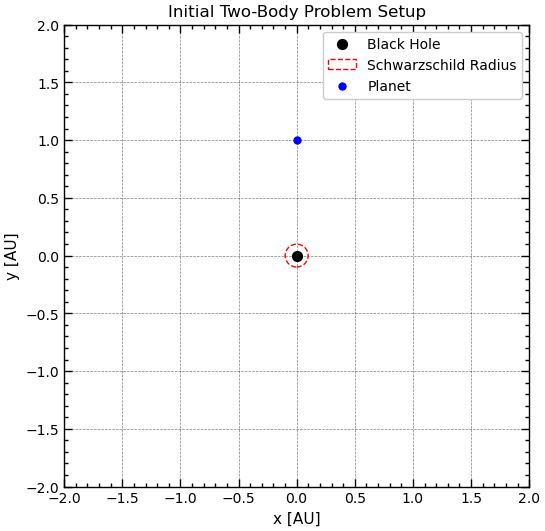

In [479]:
# Create plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2 * a, 2 * a)
ax.set_ylim(-2 * a, 2 * a)
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Initial Two-Body Problem Setup")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=50, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), R_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of orbiting body
ax.scatter(r0[0], r0[1], color='b', s=25, label="Planet")
ax.legend()
plt.show()

(cx2) includes three ODE integration methods: two own-developed methods to carry out the **Trapezoidal Euler** and **Runge-Kutta 3** integrations, and one that uses higher order **SciPy integrators** for initial value problems.

In [480]:
def slope_relativistic(t, u):
    """
    u is actual state
    u[0] is r
    u[1] is v
    """
    r = np.linalg.norm(u[0])
    L = np.linalg.norm(np.cross(u[0],u[1]))
    
    term1 = -(G*M/(r**3))*(1+(3*((L/(r*C))**2)))
    slope = np.array([u[1],term1*u[0]])
    return slope

In [481]:
def trpz(u0, t_span, dt):
    """
    u0 is array [r0, v0] where r0=[x,y] and v0=[vx,vy], all np.arrays

    """
    f = slope_relativistic
    # Initialize time array
    t_axis = np.arange(t_span[0], t_span[1] + dt, dt)
    n = len(t_axis)

    # Initialize solution array and set initial condition
    u = np.zeros((n, len(u0), len(u0[0])))
    u[0] = u0
    
    for j in range(n - 1):
        t = t_axis[j]
        u_current = u[j]
        
        u_next = u_current + dt * f(t, u_current)
        u_next = u_current + (dt/2) * (f(t, u_current) + f(t + dt, u_next))
        
        u[j+1] = u_next
    
    return u

In [485]:
u0 = np.array([r0,v0])
dt=1e-7
t_span = [0,2*T]

In [486]:
test_u = trpz(u0,t_span,dt)
r_test = test_u[:,0]
v_test = test_u[:,1]

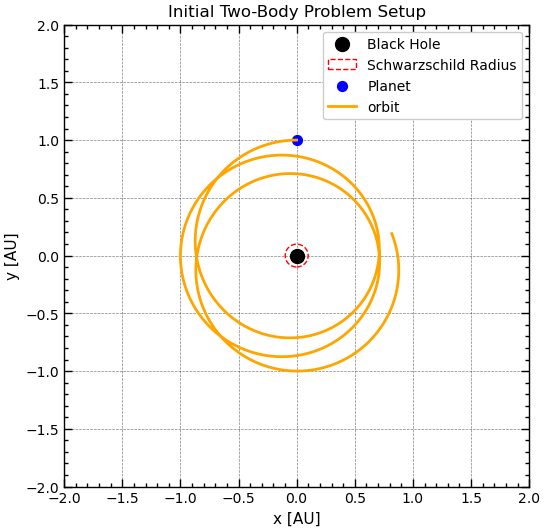

In [487]:
# Create plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2 * a, 2 * a)
ax.set_ylim(-2 * a, 2 * a)
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Initial Two-Body Problem Setup")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), R_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of orbiting body
ax.scatter(r0[0], r0[1], color='b', s=50, label="Planet")
ax.plot(r_test[:,0],r_test[:,1], color = "orange", label = "orbit")


ax.legend()
plt.show()

In [488]:
def rk4(u0, t_span, dt):
    """
    Classical RK4 (fixed-step, 4th order Runge-Kutta)
    
    Args:
        u0: Initial state [r0, v0]
        t_span: (t_start, t_end)
        dt: Time step
    
    Returns:
        u: Solution array (n_steps, 2, 2)
    """
    f = slope_relativistic
    t_axis = np.arange(t_span[0], t_span[1] + dt, dt)
    n = len(t_axis)
    
    u = np.zeros((n, len(u0), len(u0[0])))
    u[0] = u0
    
    for j in range(n - 1):
        t = t_axis[j]
        u_current = u[j]
        
        # RK4 stages
        k1 = f(t, u_current)
        k2 = f(t + dt/2, u_current + (dt/2)*k1)
        k3 = f(t + dt/2, u_current + (dt/2)*k2)
        k4 = f(t + dt, u_current + dt*k3)
        
        # Combine slopes
        u_next = u_current + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        
        u[j+1] = u_next
    
    return u

In [489]:
test_urk = rk4(u0,t_span,dt)
r_test_rk = test_urk[:,0]
v_test_rk = test_urk[:,1]

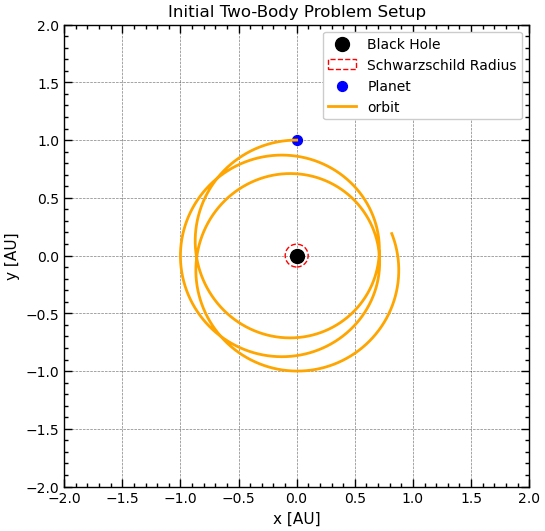

In [490]:
# Create plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2 * a, 2 * a)
ax.set_ylim(-2 * a, 2 * a)
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Initial Two-Body Problem Setup")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), R_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of orbiting body
ax.scatter(r0[0], r0[1], color='b', s=50, label="Planet")
ax.plot(r_test_rk[:,0],r_test_rk[:,1], color = "orange", label = "orbit")


ax.legend()
plt.show()

In [491]:
def slope(t, u_flat):
    """
    u_flat: Flattened state vector [x, y, vx, vy]
    Returns: Flattened derivative [vx, vy, ax, ay]
    """
    r = u_flat[:2]  # position components [x, y]
    v = u_flat[2:]  # velocity components [vx, vy]
    
    r_mag = np.linalg.norm(r)
    L = np.linalg.norm(np.cross(r, v))
    term1 = -(G*M/(r_mag**3))*(1+((3*(L/(r_mag*C))**2)))
    acceleration = term1 * r
    
    # Return flattened derivatives [vx, vy, ax, ay]
    return np.concatenate([v, acceleration])

def integrate_orbit(u0, t_span, dt, method='DOP853'):
    """
    u0: Initial state as 2x2 array [[x0, y0], [vx0, vy0]]
    t_span: Tuple (t_start, t_end)
    dt: Output time step
    method: Integration method
    Returns: Solution array with shape (n_steps, 2, 2)
    """
    # Flatten initial condition
    u0_flat = np.concatenate([u0[0], u0[1]])  # [x0, y0, vx0, vy0]
    
    # Time points for output
    t_eval = np.arange(t_span[0], t_span[1]+dt, dt)
    
    sol = solve_ivp(slope,
                    t_span=(t_eval[0],t_eval[-1]),
                    y0 =u0_flat,
                    method=method,
                    t_eval=t_eval)#, r_tol=1e-5, a_tol=1e-7)
    
    # Reshape solution to (n_steps, 2, 2)
    n_steps = len(sol.t)
    print(n_steps)
    solution = np.zeros((n_steps, 2, 2))
    solution[:, 0, :] = sol.y[:2, :].T  # Position components
    solution[:, 1, :] = sol.y[2:, :].T  # Velocity components
    
    return solution

In [492]:
# u0 = np.array([r0,v0])
# dt=10e-4
# t_span = (0,T+dt)

scsol = integrate_orbit(u0,t_span,dt)#,"RK45")

8946


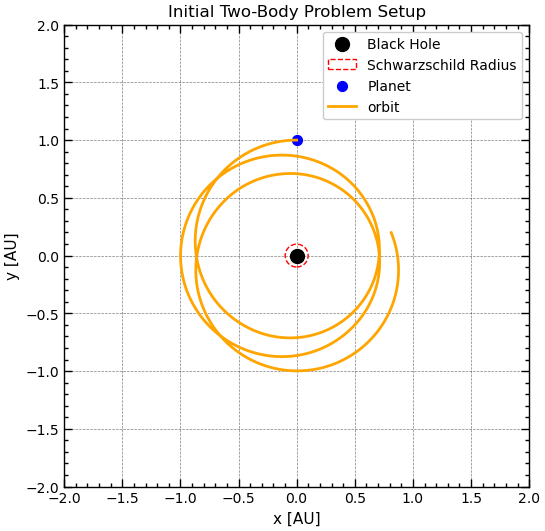

In [493]:
# Create plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2 * a, 2 * a)
ax.set_ylim(-2 * a, 2 * a)
ax.set_xlabel("x [AU]")
ax.set_ylabel("y [AU]")
ax.set_title("Initial Two-Body Problem Setup")
# Plot central black hole and Schwarzschild radius
ax.scatter(0, 0, color='k', s=100, label="Black Hole")
schwarzschild_circle = plt.Circle((0, 0), R_s, color='r', fill=False, linestyle='dashed', label="Schwarzschild Radius")
ax.add_patch(schwarzschild_circle)
# Plot initial position of orbiting body
ax.scatter(r0[0], r0[1], color='b', s=50, label="Planet")
ax.plot(scsol[:,0,0],scsol[:,0,1], color = "orange", label = "orbit")


ax.legend()
plt.show()

(dx2) includes a function for the **relativistic** and **classical** slopes given by the above equations of motion. The user should be able to select which slope to use (relativistic or classical).


(e) includes a **run class** to integrate the above system of ODEs for $N$ orbital periods and saves the history of the planet's orbital motion around the black hole into an output file inside an **outputfolder**. **Note:** Both ODEs need to be integrated simultaneously, so you don't need separate functions for the integration of each.

(f) includes an **animation class** that reads the planet's orbital history and returns a GIF animation containing the planet position and velocity at different times. The user should be able to turn on a flag at runtime to indicate if the GIF animation is desired. Use the Argparse Library to add this functionality.


(g) accepts as inputs from the user: $e$, $M$, $a$, $N$, and the numerical method to update the ODE system. Use the Argparse Library to add this functionality. **Note:** Please provide an example of how I should execute your code in the README file.

### Unit tests (2 points):

(h) Create a **test_orbits.py** file containing ```pytest``` unit tests. Provide 3 examples of pytest unit tests that could verify: a) correct input values from the user, b) handling of invalid input methods, and c) whether different inputs actually lead to different outputs.

### Relativistic versus classical mechanics (3 points):

Within your python notebook **analysis.ipynb**, add the following:

(i) Use your module/script to run and show two simulations: one relativistic and one classical for this set of initial conditions. It may be helpful to compare the orbital history in a single plot.

| Parameter | Description                                       | Units      |
|-----------|---------------------------------------------------|------------|
| $e$       | Eccentricity of the orbit                         | $0$        |
| $M$       | Mass of the central black hole                    | $5\times 10^6\,\rm M_\odot$ |
| $a$       | Semi-major axis of the orbit                      | $1\,\rm AU$|
| $N$       | Number of orbital periods to simulate             | $2$        |
| Method    | Numerical method for ODE integration              | RK3        |


(j) Use the orbital history of both simulations to design a method that quantifies their differences and evaluates the importance of using the relativistic approach for massive objects. Do we need to worry about the relativistic corrections if we replace the black hole with our Sun?


### The role of eccentricity (3 points):

(k) Use your module/script to run and show three relativistic simulations for objects with different eccentricities, $e$, and assuming the same $M$, $a$, $N$ as above. It may be helpful to compare the orbital history for all values of $e$ in a single plot throughout time.

| Object           | Eccentricity ($e$) | Integration Method |
|------------------|--------------------|--------------------|
| Earth            | 0.01671            | Trapezoidal        |
| Pluto            | 0.25               | Trapezoidal        |
| 7092 Cadmus      | 0.70               | Trapezoidal        |

(l) Describe the differences in the orbits of the above objects. What happens to objects with high eccentricities?

### Numerical convergence (3 points):

(m) Use your script to generate additional simulations with the same initial conditions as before, but only for $e=0.01671$ (Earth's eccentricity) with RK3, the Trapezoidal method and the higher-order SciPy integrator. Compare the orbital history for all methods in a single plot throughout time.

(n) Measure convergence of the simulations with RK3 and Trapezoidal method for $e=0.01671$ by integrating at a number of different time steps. To analyse convergence, you need to define some measure for the error with respect to the higher order method, and then plot it against different time steps for both methods. Thus, you may add additional functions for this to your code in **orbits.py**. 

**Note:** Please include all your simulation outputs in the **outputfolder** for a reference.


### Exam submission:

- Send your code **in a single .tar ball file via email** to wbanda@yachaytech.edu.ec by the deadline.